<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/ALCF/AD_LTEM_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [9]:
import torch
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
import numpy as np
import tifffile as tif
from matplotlib import pyplot, colors
import sys, time
from scipy import ndimage
from scipy.fftpack import *
import gdown

# will be available once we get the approval
# sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla K80


In [3]:
# truth for amplitude and phase

# will be available once we get the approval
# true_amplitude =  tif.imread('AD_LTEM/design_amp.tiff')
# true_phase = tif.imread('AD_LTEM/design_tphi.tiff')

!gdown "http://drive.google.com/uc?id=1H8wKBG_owtsM8pxwPq_O5a38omplenXk"
!gdown "http://drive.google.com/uc?id=12cyeYc_GNvfQ94IqyScxjtB08DZCwPGY"
true_amplitude =  tif.imread('design_amp.tiff')
true_phase = tif.imread('design_tphi.tiff')

true_phase -= true_phase.mean()

!gdown "http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS"
from microscopes_fwd import Microscope

Downloading...
From: http://drive.google.com/uc?id=1H8wKBG_owtsM8pxwPq_O5a38omplenXk
To: /content/design_amp.tiff
100% 1.05M/1.05M [00:00<00:00, 49.0MB/s]
Downloading...
From: http://drive.google.com/uc?id=12cyeYc_GNvfQ94IqyScxjtB08DZCwPGY
To: /content/design_tphi.tiff
100% 1.05M/1.05M [00:00<00:00, 67.5MB/s]
Downloading...
From: http://drive.google.com/uc?id=1E7cXLyjoA_DerGrlGU3aKG3IXzbN59kS
To: /content/microscopes_fwd.py
100% 10.7k/10.7k [00:00<00:00, 20.1MB/s]


In [4]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 0

defocus = np.linspace(-1.6e6,1.6e6,65)

!gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
A0 = np.load("amplitude4TIE_noise0.npy")

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise of the data set: {0:.1f}%".format((A_samples-A0).std()*200))

Downloading...
From: http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R
To: /content/amplitude4TIE_noise0.npy
136MB [00:00, 163MB/s]
Downloading...
From: http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R
To: /content/amplitude4TIE_noise0.npy
136MB [00:00, 167MB/s]
estimated noise of the data set: 0.0%


Text(0.5, 1.0, '1600000.0 nm')

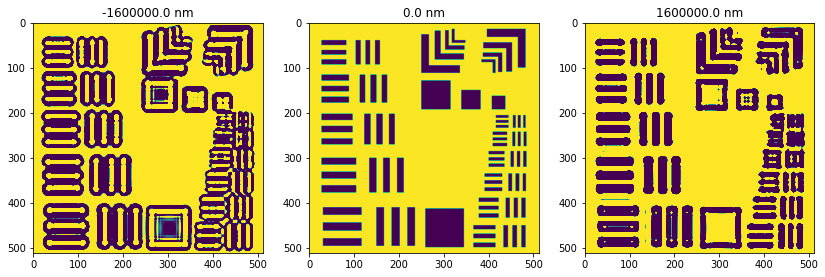

In [6]:
f, ax = pyplot.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[32], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[1].set_title("{0} nm".format(defocus[32]))
ax[2].imshow(A_samples[64], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[2].set_title("{0} nm".format(defocus[64]))

# AD Phase Retrieval

In [7]:
defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex128)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)


In [10]:
selection = [0,29,35,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = torch.from_numpy(fftshift(tf_microscope[selection], axes=(1,2)))
exp_data = torch.from_numpy(A_samples[selection])

chosen defocus (mm):  [-1.6  -0.15  0.15  1.6 ]


In [11]:
def compute_loss():
  tf_obj_real = guess_amplitude*torch.cos(guess_phase)
  tf_obj_imag = guess_amplitude*torch.sin(guess_phase)
  tf_obj = torch.complex(tf_obj_real, tf_obj_imag)
  cal_data = torch.fft.ifft2(torch.fft.fft2(tf_obj)*TF)
  cal_data = torch.abs(cal_data)
  cal_data /= torch.mean(cal_data, dim=(1,2), keepdims=True)

  return torch.mean((cal_data - exp_data)**2)

In [12]:
#guess_amplitude = torch.tensor(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype=torch.float32, requires_grad=False)
guess_amplitude = torch.tensor(A_samples[32], dtype=torch.float32, requires_grad=False)
guess_phase = torch.tensor(np.zeros(A_samples[32].shape)+0.5, dtype=torch.float32, requires_grad=True) 

opt = torch.optim.Adam([guess_phase], lr=.025)

In [13]:
def training_loop(optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = compute_loss()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)  
    return losses

In [14]:
losses = training_loop(opt, n=1000)

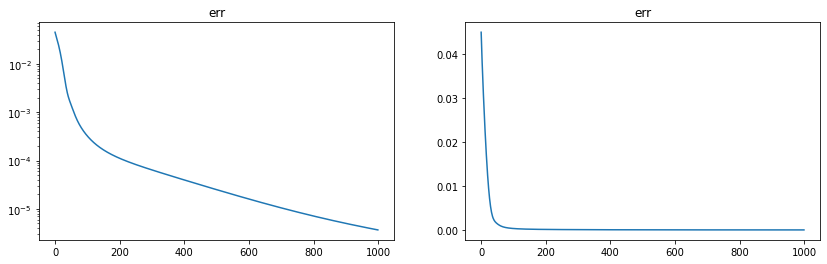

In [16]:
f, ax = pyplot.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(losses)
ax[0].set_title("err")
ax[1].plot(losses)
ax[1].set_title("err");

In [17]:
result_phase = guess_phase.detach().numpy()
result_phase -= result_phase.mean()

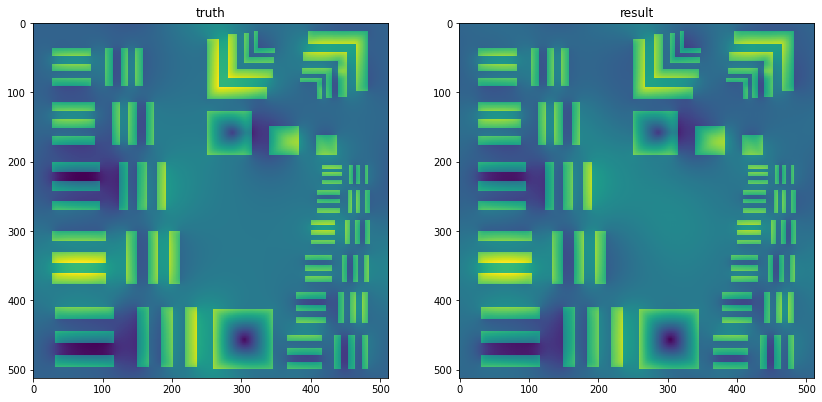

In [18]:
# show phase
f, ax = pyplot.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

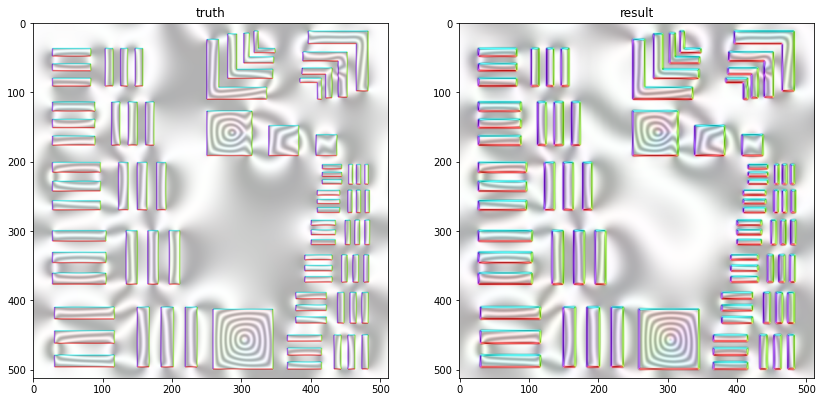

In [21]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = pyplot.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),0,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap="gray", alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap="gray", alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

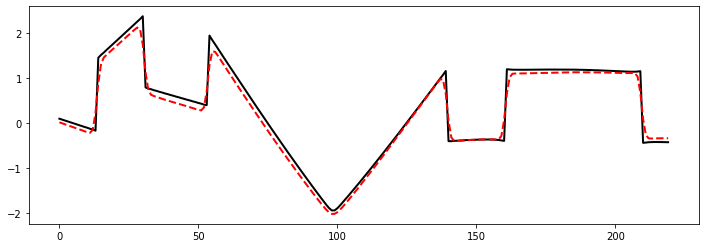

In [22]:
fig, ax = pyplot.subplots(figsize=(12,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)
ax.plot(t2[457,205:425], 'r--', linewidth=2)